# Build Predictive Model

In this stage, I will build a churn model to try to predict the churn probability of any customer, taking into account all the explanatory variables were constructed in the feature engineering process.

The Logistic Regression model is one of the most used machine learning algorithm and mainly used when the dependent variable is categorical. Churn 1 or Churn 0

## 1. Import library

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# To show plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

# Set maximum number of columns to be displayed
pd.set_option('display.max_columns', 100)

## 2. Load the data

#### Directory for the data
Paths used are indicated using the pickle data format from the data cleaning stage

In [2]:
DATA_DIR = os.path.join("..", "processed_data")
TRAINING_DATA = os.path.join(DATA_DIR, "train_data.pkl")
HISTORY_DATA = os.path.join(DATA_DIR, "history_data.pkl")

In [3]:
# Load the data into the dataframe
train_data = pd.read_pickle(TRAINING_DATA)
history_data = pd.read_pickle(HISTORY_DATA)

#### Load data into a dataframe

In [4]:
train = pd.merge(train_data, history_data, on="id")

Check we have all the data we need

In [5]:
pd.DataFrame({"Dataframe columns": train.columns})

,Dataframe columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,date_modif_prod
5,forecast_cons_12m
6,forecast_discount_energy
7,forecast_meter_rent_12m
8,forecast_price_energy_p1
9,forecast_price_energy_p2


## 3. Split the dataset

* I will split the data into the variable we are trying to predict `y` (churn) and the variables that we will use to predict the churn `x`. 
* The model will need to be trained and tested and for this we require two different datasets. 
* I will use the 80:20 split for the training:test ratio.

In [6]:
train["churn"] = train["churn"].astype(int)

In [7]:
train['date_modif_prod'] = pd.to_datetime(train['date_modif_prod'],infer_datetime_format=True)
train['date_modif_prod']=train['date_modif_prod'].apply(lambda x: x.toordinal())

In [8]:
train['price_date'] = pd.to_datetime(train['price_date'],infer_datetime_format=True)
train['price_date']=train['price_date'].apply(lambda x: x.toordinal())

In [9]:
y = train["churn"]
x = train.drop(labels = ["id", "churn"], axis = 1)

Will split the data into `training` and `test` data into 80% : 20% split; using the random state generator in order to split randomly

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=18)

In [11]:
x_train.shape[0]

154401

## 4. Build Model

#### XGboost Model

XGBoost model will be used to solve the binary classification problem, where each prediction is the probability of the input pattern belonging to the first class.


The hypothesis under consideration is that churn is driven by the customers' price sensitivities and that it would be possible to predict customers likely to churn using a predictive model. 

The outcome of the model would be churn 1 or churn 0.

In [12]:
model = xgb.XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=500,n_jobs=-1)
result = model.fit(x_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:39:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 5. Model evaluation

Will evaluate the Logistic Regression model on test data using the evaluation metrics of: Accuracy, Precision and Recall. 
* Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observations to the total observations
* Precision is the ratio of correctly predicted positive observations to the total predicted positive observations
* Recall (sensitivity) looks at the ratio of correctly predicted positive observations to the all observations in actual class

In [13]:
def evaluate(model_, x_test_, y_test_):
    """
    Evaluate the accuracy, precision and recall of a model
    """
    
    # Get the model predictions
    prediction_test_ = model_.predict(x_test_)
    
    # Print the evaluation metrics as pandas dataframe
    results = pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test_, prediction_test_)],
                           "Precision" : [metrics.precision_score(y_test_, prediction_test_)],
                           "Recall" : [metrics.recall_score(y_test_, prediction_test_)]})
    
    return results

In [14]:
evaluate(model, x_test, y_test)

,Accuracy,Precision,Recall
0,0.979793,0.999343,0.796282


The above accuracy score of `0.979793` shows that in 97.9% of the cases, the model predicted the right outcome for our binary classification problem.

### ROC-AUC

Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rates. It tells how much the model is capable of distinguishing between classes

In [15]:
def calculate_roc_auc(model_, x_test_, y_test_):
    """
    Evaluate the roc-auc score
    """
    # get model predictions
    prediction_test_ = model_.predict_proba(x_test_)[:,1]
   
    # Compute roc-auc
    fpr, tpr, thresholds = metrics.roc_curve(y_test_, prediction_test_)

    # Print the evaluation metrics as pandas dataframe
    score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})
    
    return fpr, tpr, score
    
def plot_roc_auc(fpr,tpr):
    """
    Plot the Receiver Operating Characteristics from a list of true positive rates and false positive rates.
    """
    
    # Initialise plot
    f, ax = plt.subplots(figsize=(14,8))
    
    # Plot ROC
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.3,
           label="AUC = %0.2f" % (roc_auc))
    
    # Plot the random line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
            label="Random", alpha=0.8)
    
    #Fine tune the random line
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()

In [16]:
fpr, tpr, auc_score = calculate_roc_auc(model, x_test, y_test)

In [17]:
auc_score

,ROC-AUC
0,0.999649


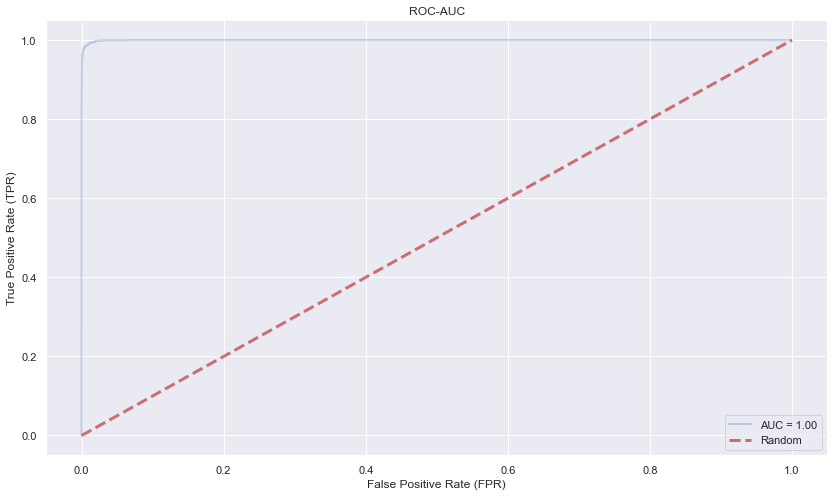

In [18]:
# plot the roc-auc curve
plot_roc_auc(fpr, tpr)
plt.show()

This ROC curve has an AUC between 0.5 and 1.0, meaning there is a high chance that the classifier will be able to distinguish between the positive class values from the negative class values. This is because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.

Real-world binary classification AUC values generally fall into this range.

## 6. Understanding the model

#### Feature importance

To help in reducing churn and take the right prevention actions in time, it is good to know whcih independent variable have the most influence on predicted outcome. 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

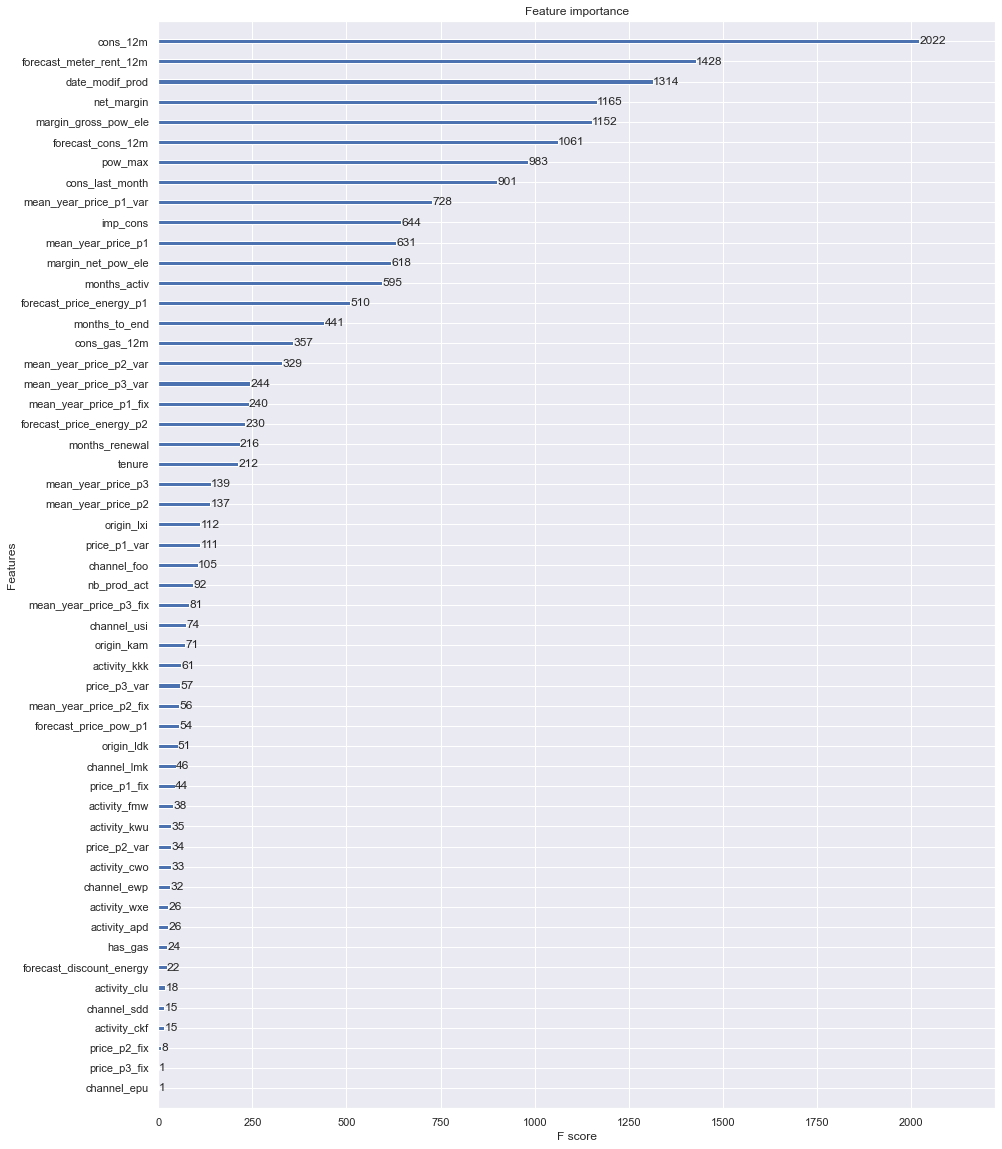

In [20]:
fig, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(model, ax=ax)

The feature importance graph shown above highlight that the features that have a significant influence and importance in the model are `cons_12m`, `forecast_meter_rent_12m` , `net_margin` and `date_modif_prod`.

This shows that yearly consumption, forecasted bill of meter over next 12 months, net margin and dates of last modification to products are the largest drivers of customer churn.

# Summary Model Solution

Data Science Problem – *Hypothesis that customers are likely churn when there is a change in price.*


The hypothesis under consideration is that churn is driven by the customers' price sensitivities and that it would be possible to predict customers likely to churn using a binary classification model as a predictive model. 

From the data collected, Exploratory Data Analysis was conducted where the data was cleaned, visualised and transformed to prepare the data for modelling. Visualisations showed that:
* Within the SME division, customer churn was high as initally highlighted in business problem from client
* 9.9% of total customer base in the SME division had churned between January 2016 and March 2016

For predictions, binary classification model was created using the XGBoost Model (XGBClassifier).
* The model created was able to predict customer churn
* The hypothesis was rejected as the model showed that customer price sensitivity is not the main driver of churn
* Feature importance graph showed that yearly consumption, forecasted bill of meter over next 12 months, net margin and dates of last modification to products are the 4 largest drivers of customer churn